In [371]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [373]:
import warnings
warnings.filterwarnings('ignore')

In [375]:
train_df = pd.read_csv('loan-train.csv')
test_df = pd.read_csv('loan-test.csv')

print(f"Train: {train_df.shape}, Test: {test_df.shape}")

Train: (614, 13), Test: (367, 12)


In [377]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [379]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [381]:
train_df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [383]:
#Handle missing values using SimpleImputer for categorical columns
mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
categorical_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']
train_df[categorical_cols] = mode_imputer.fit_transform(train_df[categorical_cols])
test_df[categorical_cols] = mode_imputer.transform(test_df[categorical_cols])

In [385]:
#Handle missing values using SimpleImputer for numerical columns
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
numerical_cols = ['LoanAmount', 'Loan_Amount_Term']
train_df[numerical_cols] = median_imputer.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = median_imputer.transform(test_df[numerical_cols])

In [387]:
le = LabelEncoder()
train_df['Loan_Status'] = le.fit_transform(train_df['Loan_Status'])

In [389]:
train_df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [391]:
# Identify all remaining categorical features
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 
                        'Credit_History', 'Property_Area']

# Drop the Loan_ID column as it is just an identifier
train_df = train_df.drop('Loan_ID', axis=1)
test_df_ids = test_df['Loan_ID']
test_df = test_df.drop('Loan_ID', axis=1)

# Apply One-Hot Encoding to both datasets
train_df_encoded = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)
test_df_encoded = pd.get_dummies(test_df, columns=categorical_features, drop_first=True)

train_feature_cols = [col for col in train_df_encoded.columns if col != 'Loan_Status']
test_feature_cols = test_df_encoded.columns.tolist()

# 2. Identify and add missing dummy columns to test_df and fill with 0
missing_cols = list(set(train_feature_cols) - set(test_feature_cols))

for col in missing_cols:
    test_df_encoded[col] = 0

test_df_encoded = test_df_encoded[train_feature_cols]

In [393]:
X = train_df_encoded.drop('Loan_Status', axis=1)
y = train_df_encoded['Loan_Status']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [397]:
# Identify numerical columns
scaling_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

# Instantiate the StandardScaler
scaler = StandardScaler()

X_train[scaling_cols] = scaler.fit_transform(X_train[scaling_cols])

X_val[scaling_cols] = scaler.transform(X_val[scaling_cols])
test_df_encoded[scaling_cols] = scaler.transform(test_df_encoded[scaling_cols])

In [399]:
#Logistic Regression
lr_model_single = LogisticRegression(
    C=0.01,
    random_state=42,
    max_iter=1000
)

lr_model_single.fit(X_train, y_train)

y_pred_lr = lr_model_single.predict(X_val)
y_pred_proba_lr = lr_model_single.predict_proba(X_val)[:, 1]

In [401]:
y_train_pred = lr_model_single.predict(X_train)
y_train_proba = lr_model_single.predict_proba(X_train)[:, 1]

print("Training Set Performance (Logistic Regression)")
print(f"Accuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall:    {recall_score(y_train, y_train_pred):.4f}")
print(f"F1-Score:  {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_train, y_train_proba):.4f}")
print("-" * 50)
print("Validation Set Performance (Logistic Regression)")
print(f"Accuracy:  {accuracy_score(y_val, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_lr):.4f}")
print(f"Recall:    {recall_score(y_val, y_pred_lr):.4f}")
print(f"F1-Score:  {f1_score(y_val, y_pred_lr):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_val, y_pred_proba_lr):.4f}")
print("-" * 50)

Training Set Performance (Logistic Regression)
Accuracy:  0.6986
Precision: 0.6980
Recall:    1.0000
F1-Score:  0.8221
ROC-AUC:   0.7810
--------------------------------------------------
Validation Set Performance (Logistic Regression)
Accuracy:  0.6504
Precision: 0.6504
Recall:    1.0000
F1-Score:  0.7882
ROC-AUC:   0.7631
--------------------------------------------------


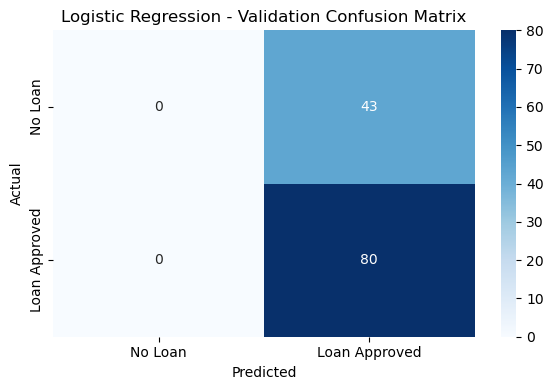

In [405]:
# Confusion Matrix for Logistic Regression
cm_lr_val = confusion_matrix(y_val, y_pred_lr)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Loan', 'Loan Approved'], 
            yticklabels=['No Loan', 'Loan Approved'])
plt.title('Logistic Regression - Validation Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [407]:
#Random Forest
# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=skf,
    verbose=1,
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)

print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best ROC-AUC Score from Cross-Validation: {grid_search_rf.best_score_:.4f}")

# Get best model and evaluate on validation set
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_val)
y_pred_proba_rf = best_rf_model.predict_proba(X_val)[:, 1]

print("\nValidation Set Performance (StratifiedKFold Tuned Random Forest)")
print(f"Accuracy:  {accuracy_score(y_val, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_val, y_pred_rf):.4f}")
print(f"F1-Score:  {f1_score(y_val, y_pred_rf):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_val, y_pred_proba_rf):.4f}")



Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters for Random Forest: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best ROC-AUC Score from Cross-Validation: 0.7632

Validation Set Performance (StratifiedKFold Tuned Random Forest)
Accuracy:  0.7724
Precision: 0.7549
Recall:    0.9625
F1-Score:  0.8462
ROC-AUC:   0.7689



Validation Confusion Matrix (Random Forest):
[[18 25]
 [ 3 77]]


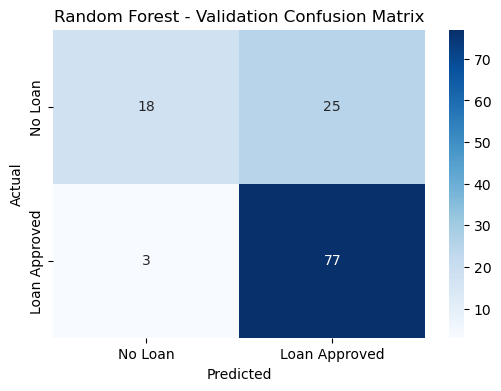

In [408]:
cm_rf = confusion_matrix(y_val, y_pred_rf)
print("\nValidation Confusion Matrix (Random Forest):")
print(cm_rf)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Loan', 'Loan Approved'], 
            yticklabels=['No Loan', 'Loan Approved'])
plt.title('Random Forest - Validation Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [427]:
# SVC with GridSearchCV
svc_model = SVC(random_state=42, probability=True, class_weight='balanced')
param_grid_svc = {
    'C': [0.1, 10.0],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 0.1]
}

grid_search_svc = GridSearchCV(
    estimator=svc_model,
    param_grid=param_grid_svc,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search_svc.fit(X_train, y_train)

# Get results from GridSearchCV (not hardcoded)
best_params_svc = grid_search_svc.best_params_
best_score_svc = grid_search_svc.best_score_
best_svc_model = grid_search_svc.best_estimator_  # Already fitted!

print(f"Best Parameters for SVC: {best_params_svc}")
print(f"Best ROC-AUC Score from Cross-Validation: {best_score_svc:.4f}")

# Predictions
y_pred_svc = best_svc_model.predict(X_val)
y_pred_proba_svc = best_svc_model.predict_proba(X_val)[:, 1]
y_train_pred_svc = best_svc_model.predict(X_train)
y_train_proba_svc = best_svc_model.predict_proba(X_train)[:, 1]

print("\nTraining Set Performance (SVC)")
print(f"Accuracy:  {accuracy_score(y_train, y_train_pred_svc):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_train, y_train_proba_svc):.4f}")
print("-" * 50)

print("Validation Set Performance (SVC)")
print(f"Accuracy:  {accuracy_score(y_val, y_pred_svc):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_svc):.4f}")
print(f"Recall:    {recall_score(y_val, y_pred_svc):.4f}")
print(f"F1-Score:  {f1_score(y_val, y_pred_svc):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_val, y_pred_proba_svc):.4f}")
print("-" * 50)

# Confusion Matrix
cm_svc_val = confusion_matrix(y_val, y_pred_svc)
print("Validation Confusion Matrix:")
print(cm_svc_val)



Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best ROC-AUC Score from Cross-Validation: 0.7569

Training Set Performance (SVC)
Accuracy:  0.7475
ROC-AUC:   0.8059
--------------------------------------------------
Validation Set Performance (SVC)
Accuracy:  0.7073
Precision: 0.7500
Recall:    0.8250
F1-Score:  0.7857
ROC-AUC:   0.7337
--------------------------------------------------
Validation Confusion Matrix:
[[21 22]
 [14 66]]


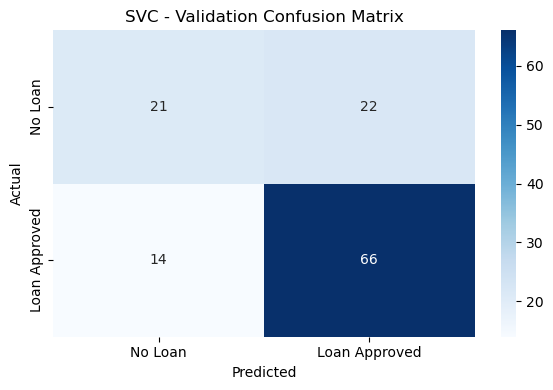

Validation Confusion Matrix (SVC):
[[21 22]
 [14 66]]


In [428]:
cm_svc_val = confusion_matrix(y_val, y_pred_svc)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svc_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Loan', 'Loan Approved'], 
            yticklabels=['No Loan', 'Loan Approved'])
plt.title('SVC - Validation Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("Validation Confusion Matrix (SVC):")
print(cm_svc_val)

In [437]:
lr_metrics = {
    'Accuracy': accuracy_score(y_val, y_pred_lr), 
    'Precision': precision_score(y_val, y_pred_lr), 
    'Recall': recall_score(y_val, y_pred_lr), 
    'F1-Score': f1_score(y_val, y_pred_lr), 
    'ROC-AUC': roc_auc_score(y_val, y_pred_proba_lr),
    'FP': confusion_matrix(y_val, y_pred_lr)[0, 1],
    'FN': confusion_matrix(y_val, y_pred_lr)[1, 0]
}

rf_metrics = {
    'Accuracy': accuracy_score(y_val, y_pred_rf),
    'Precision': precision_score(y_val, y_pred_rf),
    'Recall': recall_score(y_val, y_pred_rf),
    'F1-Score': f1_score(y_val, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_val, y_pred_proba_rf),
    'FP': confusion_matrix(y_val, y_pred_rf)[0, 1],
    'FN': confusion_matrix(y_val, y_pred_rf)[1, 0]
}

svc_metrics = {
    'Accuracy': accuracy_score(y_val, y_pred_svc),
    'Precision': precision_score(y_val, y_pred_svc),
    'Recall': recall_score(y_val, y_pred_svc),
    'F1-Score': f1_score(y_val, y_pred_svc),
    'ROC-AUC': roc_auc_score(y_val, y_pred_proba_svc),
    'FP': confusion_matrix(y_val, y_pred_svc)[0, 1],
    'FN': confusion_matrix(y_val, y_pred_svc)[1, 0]
}

In [439]:
import pandas as pd
from IPython.display import display

comparison_df = pd.DataFrame({
    'Logistic Regression': lr_metrics,
    'Random Forest': rf_metrics,
    'SVC': svc_metrics
}).T

# Round the float values for cleaner display
comparison_df_rounded = comparison_df.iloc[:, 0:5].round(4)
comparison_df_int = comparison_df.iloc[:, 5:7].astype(int)

comparison_final = pd.concat([comparison_df_rounded, comparison_df_int], axis=1)

print("--- Model Performance Comparison (Validation Set) ---")
display(comparison_final)

--- Model Performance Comparison (Validation Set) ---


,Accuracy,Precision,Recall,F1-Score,ROC-AUC,FP,FN
Logistic Regression,0.6504,0.6504,1.0000,0.7882,0.7631,43,0
Random Forest,0.7724,0.7549,0.9625,0.8462,0.7689,25,3
SVC,0.7073,0.7500,0.8250,0.7857,0.7337,22,14


In [435]:
final_predictions = best_rf_model.predict(test_df_encoded)

final_predictions_labels = pd.Series(final_predictions).map({1: 'Y', 0: 'N'})

final_submission = pd.DataFrame({
    'Loan_ID': test_df_ids,
    'Loan_Status': final_predictions_labels
})

print("\n--- Final Predictions on Unseen Test Data ---")
print("Generated final predictions using the Random Forest Classifier.")
print(f"Total Test Samples Predicted: {len(final_submission)}")
print("\nFirst 5 Final Predictions:")
print(final_submission.head())


--- Final Predictions on Unseen Test Data ---
Generated final predictions using the Random Forest Classifier.
Total Test Samples Predicted: 367

First 5 Final Predictions:
    Loan_ID Loan_Status
0  LP001015           Y
1  LP001022           Y
2  LP001031           Y
3  LP001035           Y
4  LP001051           N
